In [22]:
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [23]:
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=10.0.185.138;DATABASE=JYDB;UID=js_dev;PWD=js_dev')

# 可选消费主动基金

### 读取行业或全市场基金列表

In [268]:
df = pd.read_excel(u'../data/股票型基金行业分类.xlsx', sheet_name=u'可选消费',
                  converters = {u'代码': str}, usecols='A:C')

In [269]:
df.shape

(27, 2)

In [270]:
df.head()

,代码,名称
161725,161725,招商白酒
260108,260108,景顺成长
162605,162605,景顺鼎益
160632,160632,鹏华中证酒
110022,110022,易方达消费


### 提取基金历史累计净值

In [271]:
query = 'select t.SecuCode, t.SecuAbbr, nv.InfoPublDate, nv.UnitNV, nv.AccumulatedUnitNV \
         from MF_NetValue as nv, SecuMain as t \
         where nv.InnerCode = t.InnerCode \
             and t.SecuCode in %s \
             and nv.InfoPublDate > \'2010-07-01\' \
         order by t.SecuCode, nv.InfoPublDate'%('('+','.join(['\'%s\''%(x) for x in df[u'代码']])+')')

In [272]:
nav_sql = pd.read_sql_query(query, con=conn)

In [273]:
nav_sql.shape

(49247, 5)

In [274]:
nav_sql.head()

,SecuCode,SecuAbbr,InfoPublDate,UnitNV,AccumulatedUnitNV
0,000167,广发聚优A,2013-09-12,1.000,1.000
1,000167,广发聚优A,2013-09-14,1.004,1.004
2,000167,广发聚优A,2013-09-23,1.013,1.013
3,000167,广发聚优A,2013-09-28,1.039,1.039
4,000167,广发聚优A,2013-10-01,1.065,1.065


In [275]:
index = nav_sql['InfoPublDate'].unique().copy()
index.sort()
index = pd.to_datetime(index)

In [276]:
nav = pd.DataFrame(index=index, columns=df[u'名称'].tolist())
for code, name in zip(df[u'代码'], df[u'名称']):
    print(name)
    history = nav_sql[nav_sql['SecuCode'] == code]
    nav.loc[history['InfoPublDate'], name] = history['AccumulatedUnitNV'].values

招商白酒
景顺成长
景顺鼎益
鹏华中证酒
易方达消费
海富通内需
易方达中小盘
鹏华产业
鹏华优选
广发聚优A
易方达改革
华安宏利
景顺增长
长信多利
南方消费
景内需贰
长城品牌
银华中国梦
鹏华50
海富通选贰
天弘精选
天弘生活
海富通精选
光大中国制造
益民品质
益民红利
益民创新


### 计算基金历史绝对/超额收益

In [277]:
window = 121
nav_ret = nav.pct_change(window)

In [278]:
avg_nav_ret = nav_ret.mean(axis=1).dropna()
median_nav_ret = nav_ret.median(axis=1).dropna()

In [279]:
query = 'select csi.TradingDay, t.SecuCode, t.SecuAbbr, csi.ClosePrice \
         from QT_CSIIndexQuote as csi, SecuMain as t \
         where csi.IndexCode = t.InnerCode \
             and t.SecuCode = \'000931\' \
             and csi.TradingDay >= \'2010-07-01\' \
         order by csi.TradingDay'

In [280]:
bench = pd.read_sql_query(query, con=conn)

In [281]:
bench = bench.set_index('TradingDay')

In [282]:
bench.head()

,SecuCode,SecuAbbr,ClosePrice
TradingDay,,,
2010-07-01,000931,中证可选,3188.867
2010-07-02,000931,中证可选,3181.823
2010-07-05,000931,中证可选,3165.124
2010-07-06,000931,中证可选,3244.916
2010-07-07,000931,中证可选,3310.886


In [283]:
bench_ret = bench['ClosePrice'].pct_change(window)

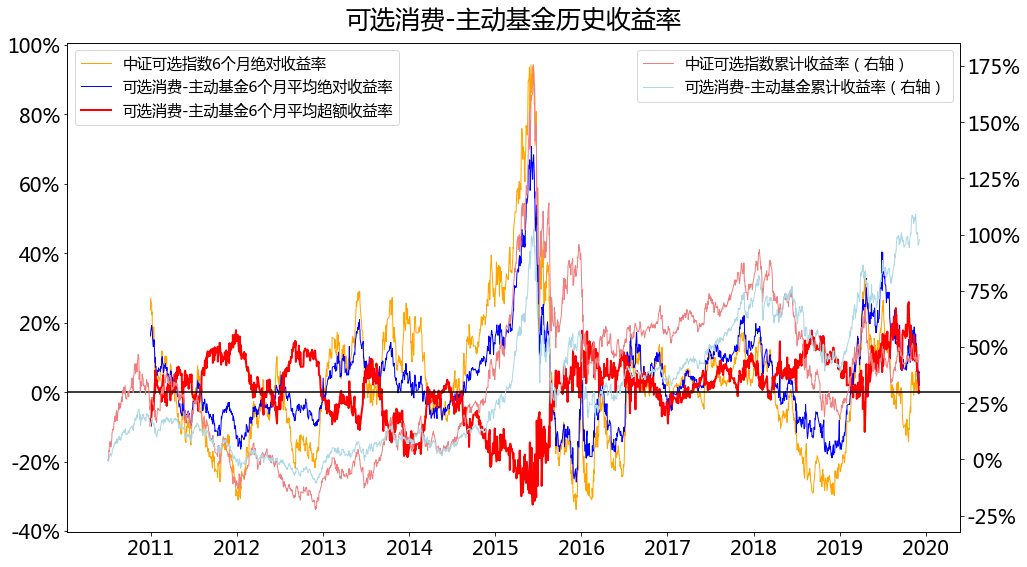

In [284]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(bench_ret, color='orange', linewidth=1, label=u'中证可选指数%d个月绝对收益率'%(window // 20))
ax.plot(avg_nav_ret, color='blue', linewidth=1, label=u'可选消费-主动基金%d个月平均绝对收益率'%(window // 20))
ax.plot((avg_nav_ret - bench_ret).dropna(), color='red', linewidth=2, label=u'可选消费-主动基金%d个月平均超额收益率'%(window // 20))
axx = ax.twinx()
axx.plot((1 + bench['ClosePrice'].pct_change()).cumprod() - 1, color='lightcoral', linewidth=1, label=u'中证可选指数累计收益率（右轴）')
axx.plot((1 + nav.pct_change().mean(axis=1)).cumprod() - 1, color='lightblue', linewidth=1, label=u'可选消费-主动基金累计收益率（右轴）')

ax.axhline(0, color='black')

ax.legend(fontsize=15, loc='upper left')
axx.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
axx.yaxis.set_tick_params(labelsize=20)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
vals = axx.get_yticks()
axx.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])

_ = ax.set_title(u'可选消费-主动基金历史收益率', fontsize=25, y=1.02)

# 必选医药主动基金

In [285]:
df = pd.read_excel(u'../data/股票型基金行业分类.xlsx', sheet_name=u'必选医药',
                  converters = {u'代码': str}, usecols='A:C')

In [286]:
query = 'select t.SecuCode, t.SecuAbbr, nv.InfoPublDate, nv.UnitNV, nv.AccumulatedUnitNV \
         from MF_NetValue as nv, SecuMain as t \
         where nv.InnerCode = t.InnerCode \
             and t.SecuCode in %s \
             and nv.InfoPublDate > \'2010-07-01\' \
         order by t.SecuCode, nv.InfoPublDate'%('('+','.join(['\'%s\''%(x) for x in df[u'代码']])+')')

In [287]:
nav_sql = pd.read_sql_query(query, con=conn)

In [288]:
nav_sql.shape

(44546, 5)

In [289]:
index = nav_sql['InfoPublDate'].unique().copy()
index.sort()
index = pd.to_datetime(index)

In [290]:
nav = pd.DataFrame(index=index, columns=df[u'名称'].tolist())
for code, name in zip(df[u'代码'], df[u'名称']):
    print(name)
    history = nav_sql[nav_sql['SecuCode'] == code]
    nav.loc[history['InfoPublDate'], name] = history['AccumulatedUnitNV'].values

中欧医疗A
中海医药A
中海医疗
工银前沿
上投医疗
易方达医疗
国泰大健康
大摩健康产业
华宝医药
博时医疗
招商医药
农银医疗
汇添富医疗
工银医疗
南方医保
易方达医药ETF
富国医疗
工银养老
华夏乐享
嘉实医疗
浦银医疗
招商生物
汇添富医药A
鹏华医药
国泰医药
鹏华医疗
华夏医疗A
融通医疗
申万医药生物
华宝医疗
汇添富医药ETF
广发医药ETF
天弘医药100A
汇添富精准A
国联安医药A


In [291]:
window = 121
nav_ret = nav.pct_change(window)

In [292]:
avg_nav_ret = nav_ret.mean(axis=1).dropna()
median_nav_ret = nav_ret.median(axis=1).dropna()

In [293]:
query = 'select csi.TradingDay, t.SecuCode, t.SecuAbbr, csi.ClosePrice \
         from QT_CSIIndexQuote as csi, SecuMain as t \
         where csi.IndexCode = t.InnerCode \
             and t.SecuCode = \'000933\' \
             and csi.TradingDay >= \'2010-07-01\' \
         order by csi.TradingDay'

In [294]:
bench = pd.read_sql_query(query, con=conn)
bench = bench.set_index('TradingDay')

In [295]:
bench_ret = bench['ClosePrice'].pct_change(window)

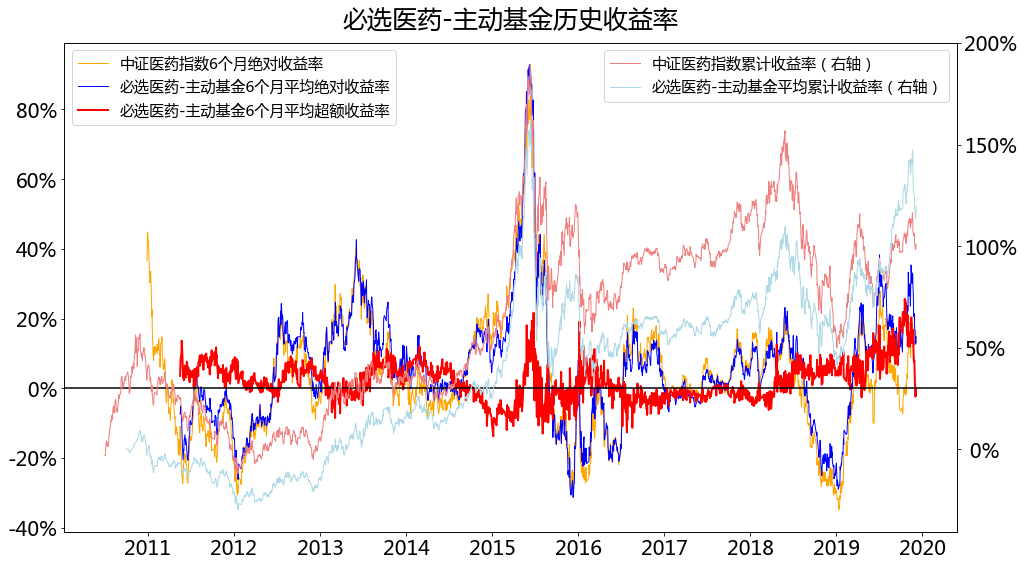

In [305]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(bench_ret, color='orange', linewidth=1, label=u'中证医药指数%d个月绝对收益率'%(window // 20))
ax.plot(avg_nav_ret, color='blue', linewidth=1, label=u'必选医药-主动基金%d个月平均绝对收益率'%(window // 20))
ax.plot((avg_nav_ret - bench_ret).dropna(), color='red', linewidth=2, label=u'必选医药-主动基金%d个月平均超额收益率'%(window // 20))
axx = ax.twinx()
axx.plot((1 + bench['ClosePrice'].pct_change()).cumprod() - 1, color='lightcoral', linewidth=1, label=u'中证医药指数累计收益率（右轴）')
axx.plot((1 + nav.pct_change().mean(axis=1)).cumprod() - 1, color='lightblue', linewidth=1, label=u'必选医药-主动基金平均累计收益率（右轴）')
# axx.plot((avg_nav_ret - bench_ret).dropna().rank(pct=True), linewidth=0.5, color='black', linestyle='--', label=u'必选医药-主动基金平均超额收益率分位数（右轴）')

ax.axhline(0, color='black')

ax.legend(fontsize=15, loc='upper left')
axx.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
axx.yaxis.set_tick_params(labelsize=20)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
vals = axx.get_yticks()
axx.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
_ = ax.set_title(u'必选医药-主动基金历史收益率', fontsize=25, y=1.02)

2010-07-01         NaN
2010-07-02         NaN
2010-07-05         NaN
2010-07-06         NaN
2010-07-07         NaN
2010-07-08         NaN
2010-07-09         NaN
2010-07-12         NaN
2010-07-13         NaN
2010-07-14         NaN
2010-07-15         NaN
2010-07-16         NaN
2010-07-19         NaN
2010-07-20         NaN
2010-07-21         NaN
2010-07-22         NaN
2010-07-23         NaN
2010-07-26         NaN
2010-07-27         NaN
2010-07-28         NaN
2010-07-29         NaN
2010-07-30         NaN
2010-08-02         NaN
2010-08-03         NaN
2010-08-04         NaN
2010-08-05         NaN
2010-08-06         NaN
2010-08-09         NaN
2010-08-10         NaN
2010-08-11         NaN
                ...   
2019-11-02         NaN
2019-11-04    0.979641
2019-11-05    0.968263
2019-11-06    0.975449
2019-11-07    0.967665
2019-11-08    0.955090
2019-11-09         NaN
2019-11-11    0.973054
2019-11-12    0.987425
2019-11-13    0.986228
2019-11-14    0.990419
2019-11-15    0.993413
2019-11-16 

# 信息科技主动基金

In [230]:
df = pd.read_excel(u'../data/股票型基金行业分类.xlsx', sheet_name=u'信息科技',
                  converters = {u'代码': str}, usecols='A:C')

In [231]:
query = 'select t.SecuCode, t.SecuAbbr, nv.InfoPublDate, nv.UnitNV, nv.AccumulatedUnitNV \
         from MF_NetValue as nv, SecuMain as t \
         where nv.InnerCode = t.InnerCode \
             and t.SecuCode in %s \
             and nv.InfoPublDate > \'2010-07-01\' \
         order by t.SecuCode, nv.InfoPublDate'%('('+','.join(['\'%s\''%(x) for x in df[u'代码']])+')')

In [232]:
nav_sql = pd.read_sql_query(query, con=conn)

In [233]:
nav_sql.shape

(133066, 5)

In [234]:
index = nav_sql['InfoPublDate'].unique().copy()
index.sort()
index = pd.to_datetime(index)

In [235]:
nav = pd.DataFrame(index=index, columns=df[u'名称'].tolist())
for code, name in zip(df[u'代码'], df[u'名称']):
    print(name)
    history = nav_sql[nav_sql['SecuCode'] == code]
    nav.loc[history['InfoPublDate'], name] = history['AccumulatedUnitNV'].values

信达新能源
交银新生活力
交银经济
广发创新
银河创新
交银双息
广发小盘
华安媒体
易方达信息
富国科技
宝盈鸿利A
交银核心
景顺品质
中海分红
交银行业
富国主题
财通价值
海富通股票
农银精选
交银30
国泰互联网
财通优选
华宝创新
上投新兴A
泓德远见
天弘互联网
农银领先
国泰新经济
华夏经济转型
博时回报
华安灵活
南方高端A
嘉实智能汽车
宝盈制造A
工银战略
富国中小盘
嘉实动力
国联安科技
华夏创新
易方达新兴
博时特许A
宝盈科技
嘉实文体A
嘉实环保
国联安优选
交银数据
交银科技
前海智能
嘉实逆向
广发制造
申万电子
天弘中证电子A
宝盈核心A
汇丰新动力
申万新能源
华宝生态
泰达成长
鹏华信息
工银信息
华富成长
农银信息传媒
南方信息ETF
富国国家
长盛高端
华安物联网
中海量化
中邮中小盘
嘉实新收益
诺安成长
汇丰科技
国泰TMT50
华夏复兴
中银智能
光大一带一路
招商深证TMT50ETF
天弘计算机A
富国工业4.0
富国互联
中海能源
交银先锋
广发信息ETF
中邮优选
景顺TMT150ETF
中邮信息
长盛电子
长信电子信息
汇添富移动
工银互联网
长盛信息主题
中邮战略
鹏华传媒


In [236]:
window = 121
nav_ret = nav.pct_change(window)

In [237]:
avg_nav_ret = nav_ret.mean(axis=1).dropna()
median_nav_ret = nav_ret.median(axis=1).dropna()

In [238]:
query = 'select csi.TradingDay, t.SecuCode, t.SecuAbbr, csi.ClosePrice \
         from QT_CSIIndexQuote as csi, SecuMain as t \
         where csi.IndexCode = t.InnerCode \
             and t.SecuCode = \'000935\' \
             and csi.TradingDay >= \'2010-07-01\' \
         order by csi.TradingDay'

In [239]:
bench = pd.read_sql_query(query, con=conn)
bench = bench.set_index('TradingDay')

In [240]:
bench_ret = bench['ClosePrice'].pct_change(window)

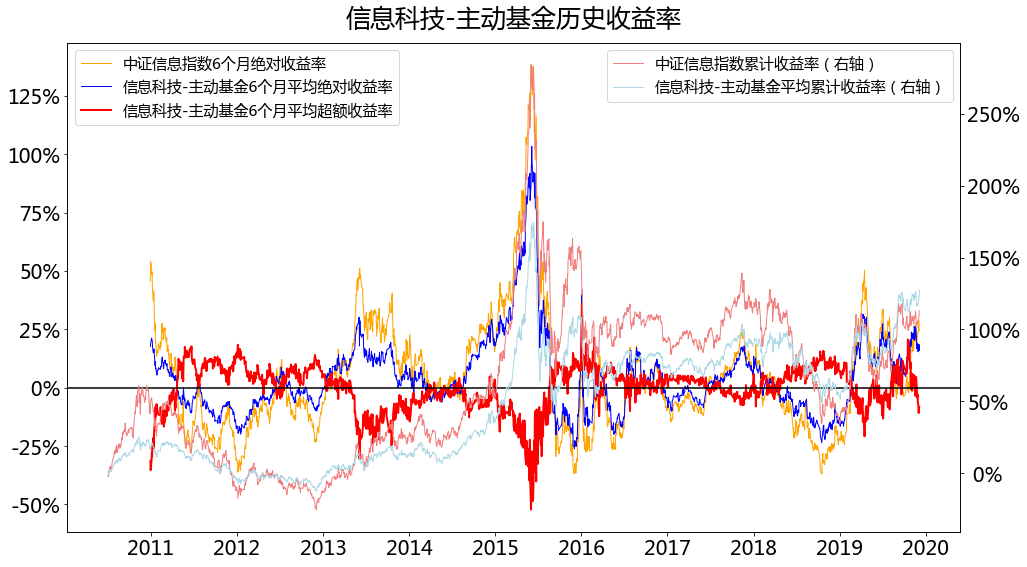

In [241]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(bench_ret, color='orange', linewidth=1, label=u'中证信息指数%d个月绝对收益率'%(window // 20))
ax.plot(avg_nav_ret, color='blue', linewidth=1, label=u'信息科技-主动基金%d个月平均绝对收益率'%(window // 20))
ax.plot((avg_nav_ret - bench_ret).dropna(), color='red', linewidth=2, label=u'信息科技-主动基金%d个月平均超额收益率'%(window // 20))
axx = ax.twinx()
axx.plot((1 + bench['ClosePrice'].pct_change()).cumprod() - 1, color='lightcoral', linewidth=1, label=u'中证信息指数累计收益率（右轴）')
axx.plot((1 + nav.pct_change().mean(axis=1)).cumprod() - 1, color='lightblue', linewidth=1, label=u'信息科技-主动基金平均累计收益率（右轴）')

ax.axhline(0, color='black')

ax.legend(fontsize=15, loc='upper left')
axx.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
axx.yaxis.set_tick_params(labelsize=20)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
vals = axx.get_yticks()
axx.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
_ = ax.set_title(u'信息科技-主动基金历史收益率', fontsize=25, y=1.02)

# 金融地产主动基金

In [242]:
df = pd.read_excel(u'../data/股票型基金行业分类.xlsx', sheet_name=u'金融地产',
                  converters = {u'代码': str}, usecols='A:C')

In [243]:
query = 'select t.SecuCode, t.SecuAbbr, nv.InfoPublDate, nv.UnitNV, nv.AccumulatedUnitNV \
         from MF_NetValue as nv, SecuMain as t \
         where nv.InnerCode = t.InnerCode \
             and t.SecuCode in %s \
             and nv.InfoPublDate > \'2010-07-01\' \
         order by t.SecuCode, nv.InfoPublDate'%('('+','.join(['\'%s\''%(x) for x in df[u'代码']])+')')

In [244]:
nav_sql = pd.read_sql_query(query, con=conn)

In [245]:
nav_sql.shape

(50572, 5)

In [246]:
index = nav_sql['InfoPublDate'].unique().copy()
index.sort()
index = pd.to_datetime(index)

In [247]:
nav = pd.DataFrame(index=index, columns=df[u'名称'].tolist())
for code, name in zip(df[u'代码'], df[u'名称']):
    print(name)
    history = nav_sql[nav_sql['SecuCode'] == code]
    nav.loc[history['InfoPublDate'], name] = history['AccumulatedUnitNV'].values

华润中国A50
方正保险
工银地产
博时50ETF
中海50
天弘上证50A
申万300价值A
银河300
易方达上证50
招商中证银行
华夏50ETF
易方达银行
国投金地ETF
万家瑞兴
天弘中证银行A
国泰金融ETF
广发金融ETF
华安银行
易方达非银ETF
鹏华银行
信诚金融
万家新利
天弘证保A
万家精选
鹏华地产
中银宏观
鹏华证保
南方中国梦
国泰房地产
易方达证券
国泰证券ETF
富国证券
华宝券商ETF
鹏华证券
华安证券
申万证券
招商中证证券


In [248]:
window = 121
nav_ret = nav.pct_change(window)

In [249]:
avg_nav_ret = nav_ret.mean(axis=1).dropna()
median_nav_ret = nav_ret.median(axis=1).dropna()

In [251]:
query = 'select csi.TradingDay, t.SecuCode, t.SecuAbbr, csi.ClosePrice \
         from QT_CSIIndexQuote as csi, SecuMain as t \
         where csi.IndexCode = t.InnerCode \
             and t.SecuCode = \'000934\' \
             and csi.TradingDay >= \'2010-07-01\' \
         order by csi.TradingDay'

In [252]:
bench = pd.read_sql_query(query, con=conn)
bench = bench.set_index('TradingDay')

In [253]:
bench_ret = bench['ClosePrice'].pct_change(window)

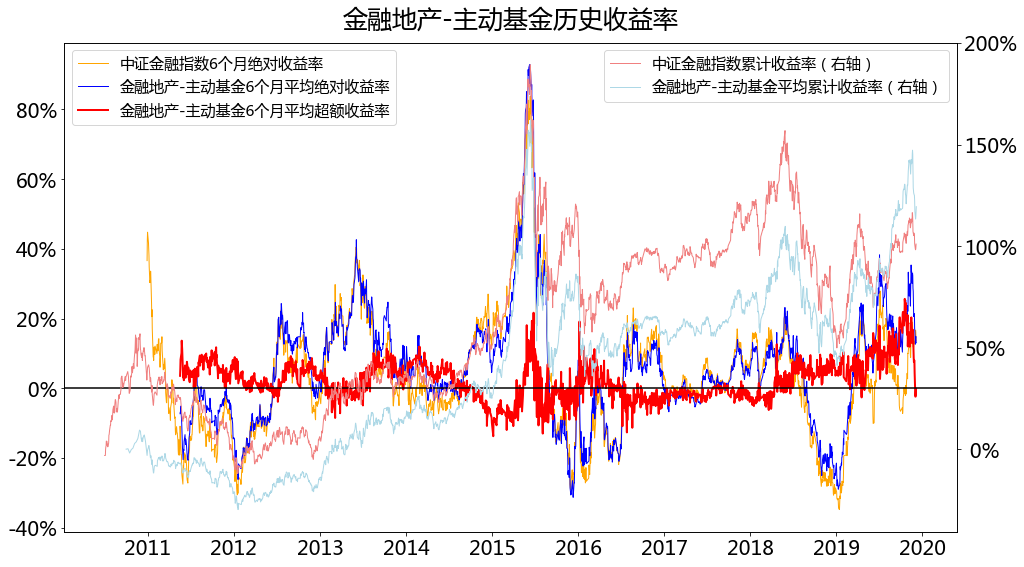

In [297]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(bench_ret, color='orange', linewidth=1, label=u'中证金融指数%d个月绝对收益率'%(window // 20))
ax.plot(avg_nav_ret, color='blue', linewidth=1, label=u'金融地产-主动基金%d个月平均绝对收益率'%(window // 20))
ax.plot((avg_nav_ret - bench_ret).dropna(), color='red', linewidth=2, label=u'金融地产-主动基金%d个月平均超额收益率'%(window // 20))
axx = ax.twinx()
axx.plot((1 + bench['ClosePrice'].pct_change()).cumprod() - 1, color='lightcoral', linewidth=1, label=u'中证金融指数累计收益率（右轴）')
axx.plot((1 + nav.pct_change().mean(axis=1)).cumprod() - 1, color='lightblue', linewidth=1, label=u'金融地产-主动基金平均累计收益率（右轴）')

ax.axhline(0, color='black')

ax.legend(fontsize=15, loc='upper left')
axx.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
axx.yaxis.set_tick_params(labelsize=20)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
vals = axx.get_yticks()
axx.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
_ = ax.set_title(u'金融地产-主动基金历史收益率', fontsize=25, y=1.02)

# 全市场主动基金

In [255]:
df = pd.read_excel(u'../data/股票型基金行业分类.xlsx', sheet_name=u'全市场',
                  converters = {u'代码': str}, usecols='A:C')

In [256]:
query = 'select t.SecuCode, t.SecuAbbr, nv.InfoPublDate, nv.UnitNV, nv.AccumulatedUnitNV \
         from MF_NetValue as nv, SecuMain as t \
         where nv.InnerCode = t.InnerCode \
             and t.SecuCode in %s \
             and nv.InfoPublDate > \'2010-07-01\' \
         order by t.SecuCode, nv.InfoPublDate'%('('+','.join(['\'%s\''%(x) for x in df[u'代码']])+')')

In [257]:
nav_sql = pd.read_sql_query(query, con=conn)

In [258]:
nav_sql.shape

(1283628, 5)

In [259]:
index = nav_sql['InfoPublDate'].unique().copy()
index.sort()
index = pd.to_datetime(index)

In [260]:
nav = pd.DataFrame(index=index, columns=df[u'名称'].tolist())
for code, name in zip(df[u'代码'], df[u'名称']):
#     print(name)
    history = nav_sql[nav_sql['SecuCode'] == code]
    nav.loc[history['InfoPublDate'], name] = history['AccumulatedUnitNV'].values

In [261]:
window = 121
nav_ret = nav.pct_change(window)

In [262]:
avg_nav_ret = nav_ret.mean(axis=1).dropna()
median_nav_ret = nav_ret.median(axis=1).dropna()

In [263]:
query = 'select csi.TradingDay, t.SecuCode, t.SecuAbbr, csi.ClosePrice \
         from QT_CSIIndexQuote as csi, SecuMain as t \
         where csi.IndexCode = t.InnerCode \
             and t.SecuCode = \'000916\' \
             and csi.TradingDay >= \'2010-07-01\' \
         order by csi.TradingDay'

In [264]:
bench = pd.read_sql_query(query, con=conn)
bench = bench.set_index('TradingDay')

In [265]:
bench_ret = bench['ClosePrice'].pct_change(window)

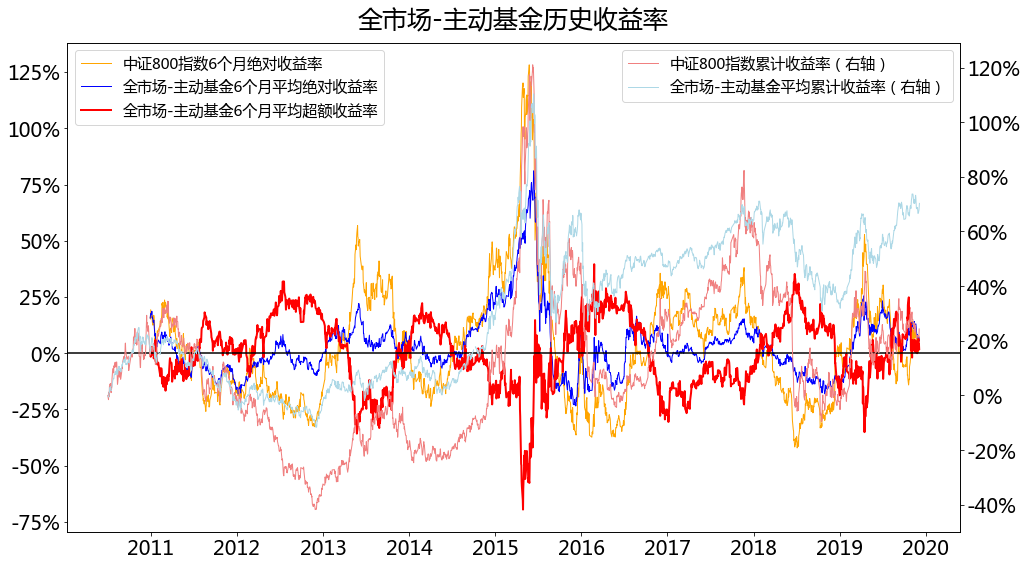

In [267]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(bench_ret, color='orange', linewidth=1, label=u'中证800指数%d个月绝对收益率'%(window // 20))
ax.plot(avg_nav_ret, color='blue', linewidth=1, label=u'全市场-主动基金%d个月平均绝对收益率'%(window // 20))
ax.plot((avg_nav_ret - bench_ret).dropna(), color='red', linewidth=2, label=u'全市场-主动基金%d个月平均超额收益率'%(window // 20))
axx = ax.twinx()
axx.plot((1 + bench['ClosePrice'].pct_change()).cumprod() - 1, color='lightcoral', linewidth=1, label=u'中证800指数累计收益率（右轴）')
axx.plot((1 + nav.pct_change().mean(axis=1)).cumprod() - 1, color='lightblue', linewidth=1, label=u'全市场-主动基金平均累计收益率（右轴）')

ax.axhline(0, color='black')

ax.legend(fontsize=15, loc='upper left')
axx.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
axx.yaxis.set_tick_params(labelsize=20)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
vals = axx.get_yticks()
axx.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])
_ = ax.set_title(u'全市场-主动基金历史收益率', fontsize=25, y=1.02)